# Importing the data
### setting comprehensible col names and right types

In [91]:
# Importing all the necessary packages
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from pmdarima import auto_arima
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import FourierFeaturizer
from prophet import Prophet

# For legibility, we mute some warnings
import warnings

# Ignore FutureWarning for deprecated 'T' frequency in Prophet
warnings.filterwarnings("ignore", category=FutureWarning, message="'T' is deprecated")

# Ignore PerformanceWarning from pandas
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)


In [119]:
# Mix of different sources, mostly ESO
balancing_df = pd.read_csv("balancing_data.csv")
# Demand data only for GB
GB_demand_df = pd.read_csv("demand_load_data.csv")
# Generation data only for GB
GB_generation_df = pd.read_csv("generation_data.csv")
# the price dataframe only concerns EPEX (only prices from there)
EPEX_price_df = pd.read_csv("price_data.csv")

#### So the result is as expected, we filled wherever we could but there is no way of filling System_Price . No way of filling NIV_Outturn when the two of its composites are missing. No way of filling the BM things when 2 or more of the equation are missing. and same for BSAD, they are either filled or all NaNs bc we couldnt fill. EPEX volume, idk with what to fill

In [ ]:
balancing_df.describe()

System_Price    NIV_Outturn  BM_Bid_Acceptances  BM_Offer_Acceptances  \
count  118320.000000  118320.000000       117900.000000         117900.000000   
mean       87.634050      14.903264        -1571.115056           1555.173754   
std       103.059107     660.283820         1158.581274           1140.893710   
min      -185.330000   -4954.350000       -11283.670000              0.000000   
25%        38.800000    -363.380000        -2192.007500            682.480000   
50%        60.950000       2.275000        -1279.465000           1292.270000   
75%       108.000000     393.970000         -691.010000           2203.297500   
max      4037.800000    4566.920000            0.000000          10270.560000   

       BSAD_Turn_Up  BSAD_Turn_Down    BSAD_Total  EPEX_Intraday_Volume  \
count  81271.000000    81271.000000  81271.000000         118320.000000   
mean     431.959006     -512.683037    -80.724031           1239.624493   
std      550.280876      763.928928    922.975701            638.445619   
min        0.000000    -6226.000000  -6226.000000              0.000000   
25%        9.410000     -789.000000   -512.000000            768.587500   
50%      234.820000     -114.000000     18.000000           1158.250000   
75%      632.780000        0.000000    360.000000           1609.650000   
max     6200.000000        0.000000   6200.000000           4991.000000   

       Loss_of_Load_Prob     Total_Load  ...  Hydro_Pumped_Storage  \
count      117764.000000  116229.000000  ...         118320.000000   
mean            0.000133   32493.608032  ...            211.713404   
std             0.005395    7950.067231  ...            357.571976   
min             0.000000     203.000000  ...              0.000000   
25%             0.000000   26629.000000  ...              0.000000   
50%             0.000000   32744.000000  ...              0.000000   
75%             0.000000   38246.000000  ...            300.000000   
max             0.700000   71273.000000  ...           2473.000000   

       Hydro_Run-of-River_and_Poundage        Nuclear          Solar  \
count                    118320.000000  118320.000000  118320.000000   
mean                        382.065969    5200.154205    1309.637796   
std                         245.872786    1432.629830    2020.443577   
min                           0.000000       0.000000       0.000000   
25%                         176.000000    4551.000000       0.000000   
50%                         354.000000    5202.000000      17.000000   
75%                         551.000000    6165.000000    2120.000000   
max                        1424.000000    8330.000000   10322.000000   

        Wind_Onshore  Wind_Offshore     Wind_Solar  Total_Generation  \
count  118320.000000  118320.000000  118320.000000     118320.000000   
mean     2998.296420    2670.895085    6978.829300      33346.771159   
std      2010.140457    2273.396307    4139.751808       9368.752960   
min         0.000000     -38.510000       0.000000        932.480000   
25%      1329.260000     794.807500    3659.032500      26870.330000   
50%      2531.635000    2050.850000    6477.025000      33244.860000   
75%      4331.987500    4104.632500    9673.752500      40174.915000   
max     11207.950000   11631.920000   28456.160000      67827.500000   

       Day_Ahead_Price  Intraday_Price  
count    118256.000000   117680.000000  
mean         89.006159       86.896807  
std          81.321488       78.471789  
min         -86.300000      -77.290000  
25%          43.700000       42.470000  
50%          64.100000       62.700000  
75%         102.400000      101.922500  
max        2500.000000     1983.660000  

[8 rows x 25 columns]

### Correlations

In [ ]:
# Calculate correlations with the target variable
correlations = balancing_df.drop(columns=["Datetime"]).corr(method='spearman')['System_Price'].abs()

# Sort by highest absolute correlation and exclude the target itself
correlations = correlations.drop('System_Price').sort_values(ascending=False)

# Display the top correlated variables
print("Most correlated variables with System_Price:\n")
print(correlations)

Most correlated variables with System_Price:

Intraday_Price                     0.831153
Day_Ahead_Price                    0.768770
NIV_Outturn                        0.540756
BSAD_Turn_Down                     0.486031
BSAD_Total                         0.399471
BM_Bid_Acceptances                 0.362629
Nuclear                            0.266730
Demand_Outturn                     0.213778
Fossil_Gas                         0.189681
Hydro_Pumped_Storage               0.179998
EPEX_Intraday_Volume               0.157302
Generation-Demand                  0.150187
BSAD_Turn_Up                       0.143762
LoLP_lag1                          0.121312
LoLP                               0.120210
Fossil_Hard_Coal                   0.111573
Wind_Solar                         0.105356
LoLP_Gen                           0.103125
LoLP_Gen_lag1                      0.101998
Load-Demand                        0.094652
Wind_Onshore                       0.087828
Total_Load                    

In [ ]:
# Calculate the correlation matrix
predictors = balancing_df.drop(columns=['System_Price', "Datetime"])
correlation_matrix = predictors.corr().abs()

threshold = 0.8

# Identify pairs of highly correlated features
high_corr_pairs = [(column, idx) for column in correlation_matrix.columns for idx in correlation_matrix.index 
                   if correlation_matrix.loc[column, idx] > threshold and column != idx]

print(f"Highly correlated pairs (correlation > {threshold}):\n", high_corr_pairs)


Highly correlated pairs (correlation > 0.8):
 [('BM_Bid_Acceptances', 'BM_Offer_Acceptances'), ('BM_Offer_Acceptances', 'BM_Bid_Acceptances'), ('BSAD_Turn_Down', 'BSAD_Total'), ('BSAD_Total', 'BSAD_Turn_Down'), ('Total_Load', 'Demand_Outturn'), ('Demand_Outturn', 'Total_Load'), ('LoLP', 'LoLP_lag1'), ('LoLP_lag1', 'LoLP'), ('Wind_Onshore', 'Wind_Solar'), ('Wind_Solar', 'Wind_Onshore'), ('Day_Ahead_Price', 'Intraday_Price'), ('Intraday_Price', 'Day_Ahead_Price'), ('Exports-Imports-Stored', 'Generation-Demand'), ('Generation-Demand', 'Exports-Imports-Stored')]


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

#  Just trying some stuff out
#  Like can the cols be autocorrelated 
#  Commented out for the moment bc runs for a long time

"""
def ljungbox(data, lags):
    # Run Ljung-Box test and handle output as DataFrame
    lb_result = acorr_ljungbox(data, lags=lags, return_df=True)

    # Access the p-value from the DataFrame
    p_value = lb_result['lb_pvalue'].iloc[0]
    print("acorr_ljungbox test")
    print("H0: The series exhibits white noise (no significant autocorrelation).", "H1: The series does not exhibit white noise (significant autocorrelation present).")
    print(f"p-value: {p_value:.4f}")
    
    # Conditional interpretation of the test result
    if p_value > 0.05:
        print(f"With {lags[0]} lags, we fail to reject H0: the series is consistent with white noise.")
    else:
        print(f"With {lags[0]} lags, we reject H0: the series exhibits significant autocorrelation, inconsistent with white noise.")

for col in merged_df.columns:
    if col != "Datetime":
        print(col)
        ljungbox(merged_df[col], [48*10])
"""


'\ndef ljungbox(data, lags):\n    # Run Ljung-Box test and handle output as DataFrame\n    lb_result = acorr_ljungbox(data, lags=lags, return_df=True)\n\n    # Access the p-value from the DataFrame\n    p_value = lb_result[\'lb_pvalue\'].iloc[0]\n    print("acorr_ljungbox test")\n    print("H0: The series exhibits white noise (no significant autocorrelation).", "H1: The series does not exhibit white noise (significant autocorrelation present).")\n    print(f"p-value: {p_value:.4f}")\n    \n    # Conditional interpretation of the test result\n    if p_value > 0.05:\n        print(f"With {lags[0]} lags, we fail to reject H0: the series is consistent with white noise.")\n    else:\n        print(f"With {lags[0]} lags, we reject H0: the series exhibits significant autocorrelation, inconsistent with white noise.")\n\nfor col in merged_df.columns:\n    if col != "Datetime":\n        print(col)\n        ljungbox(merged_df[col], [48*10])\n'

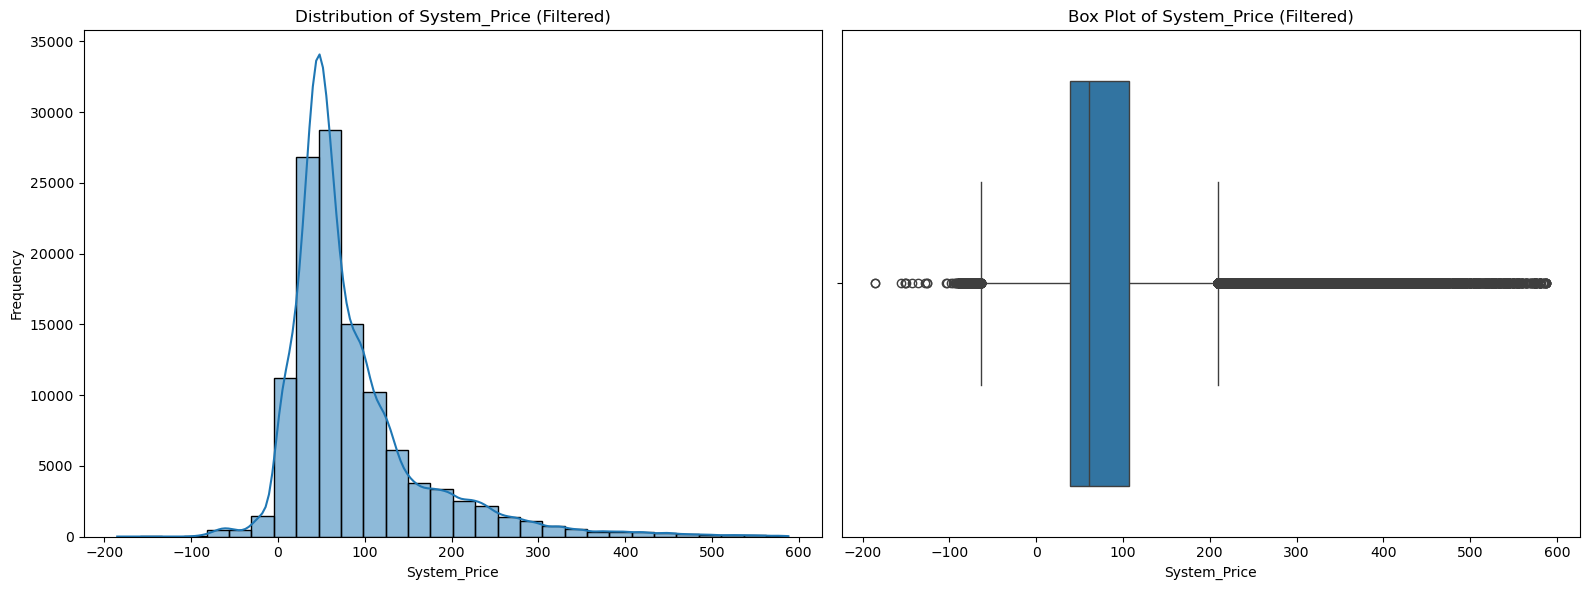

In [ ]:
import seaborn as sns

# Define a threshold, e.g., 95th percentile
threshold = balancing_df['System_Price'].quantile(0.9975)

# Filter the data to exclude extreme outliers
filtered_data = balancing_df[balancing_df['System_Price'] <= threshold]

# Plot the filtered data
plt.figure(figsize=(16, 6))

# Histogram and Density Plot
plt.subplot(1, 2, 1)
sns.histplot(filtered_data['System_Price'], kde=True, bins=30)
plt.title('Distribution of System_Price (Filtered)')
plt.xlabel('System_Price')
plt.ylabel('Frequency')

# Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(x=filtered_data['System_Price'])
plt.title('Box Plot of System_Price (Filtered)')
plt.xlabel('System_Price')

plt.tight_layout()
plt.show()


# Seasonality analysis

### System_Price variable analysis

### Visual Inspection

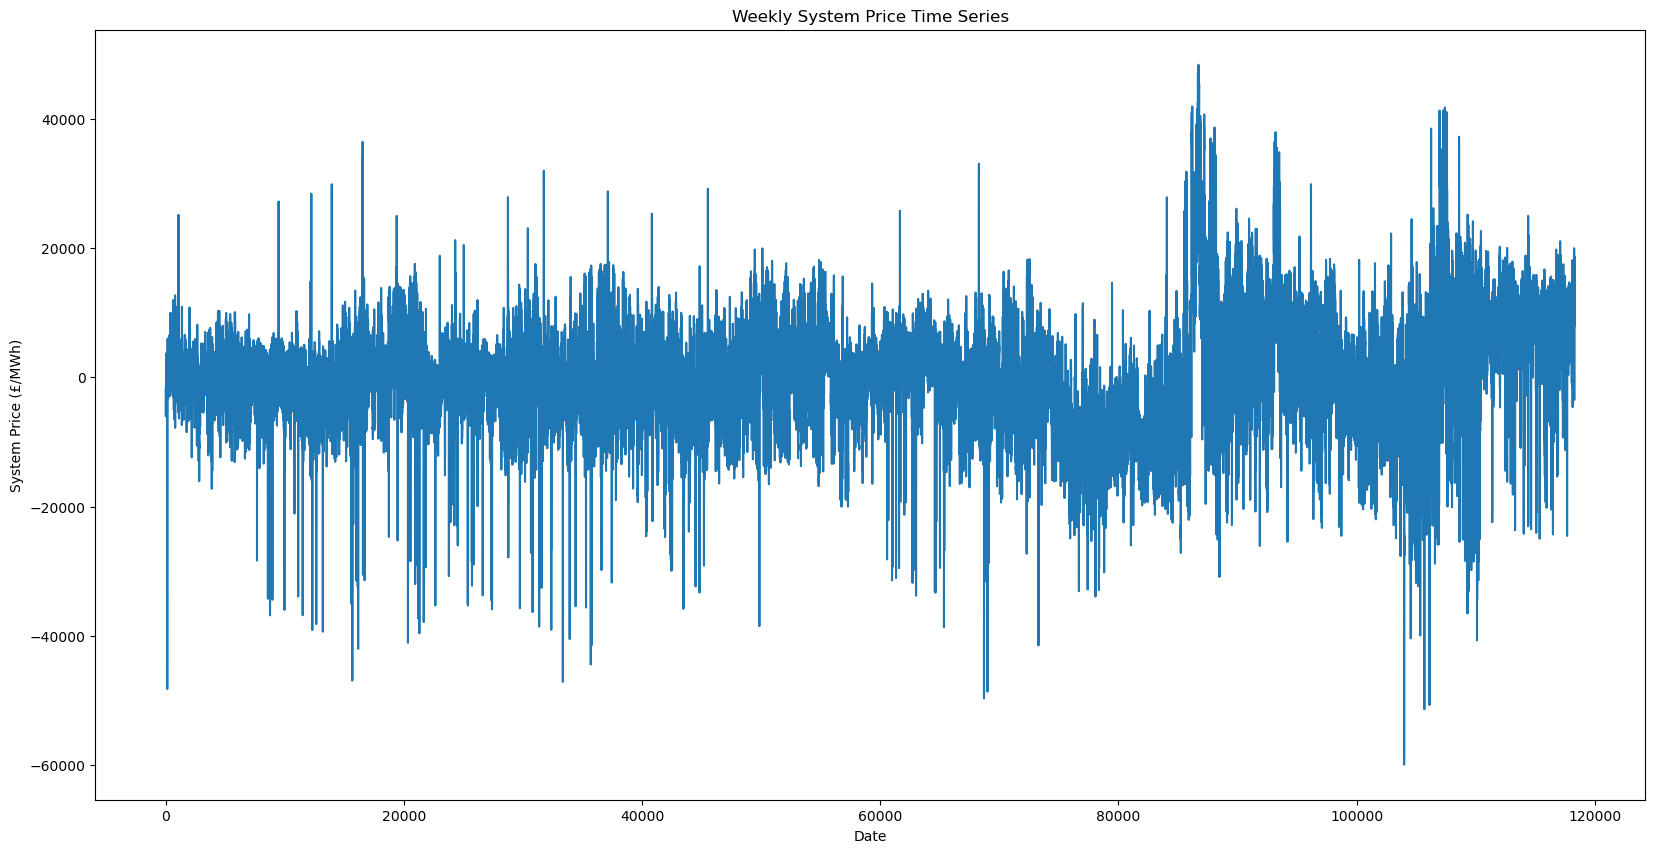

In [ ]:
# Plotting the System Price over a shorter period to check daily patterns
balancing_df["System_Price"].plot(figsize=(20, 10))
plt.title('Weekly System Price Time Series')
plt.xlabel('Date')
plt.ylabel('System Price (£/MWh)')
plt.show()

### The following is only for last 365 because the rest is messed up during covid

In [16]:
balancing_df_2024 = balancing_df[(balancing_df.index >= '2023-10-01') & (balancing_df.index < '9999-01-01')]  # we only look at 2024

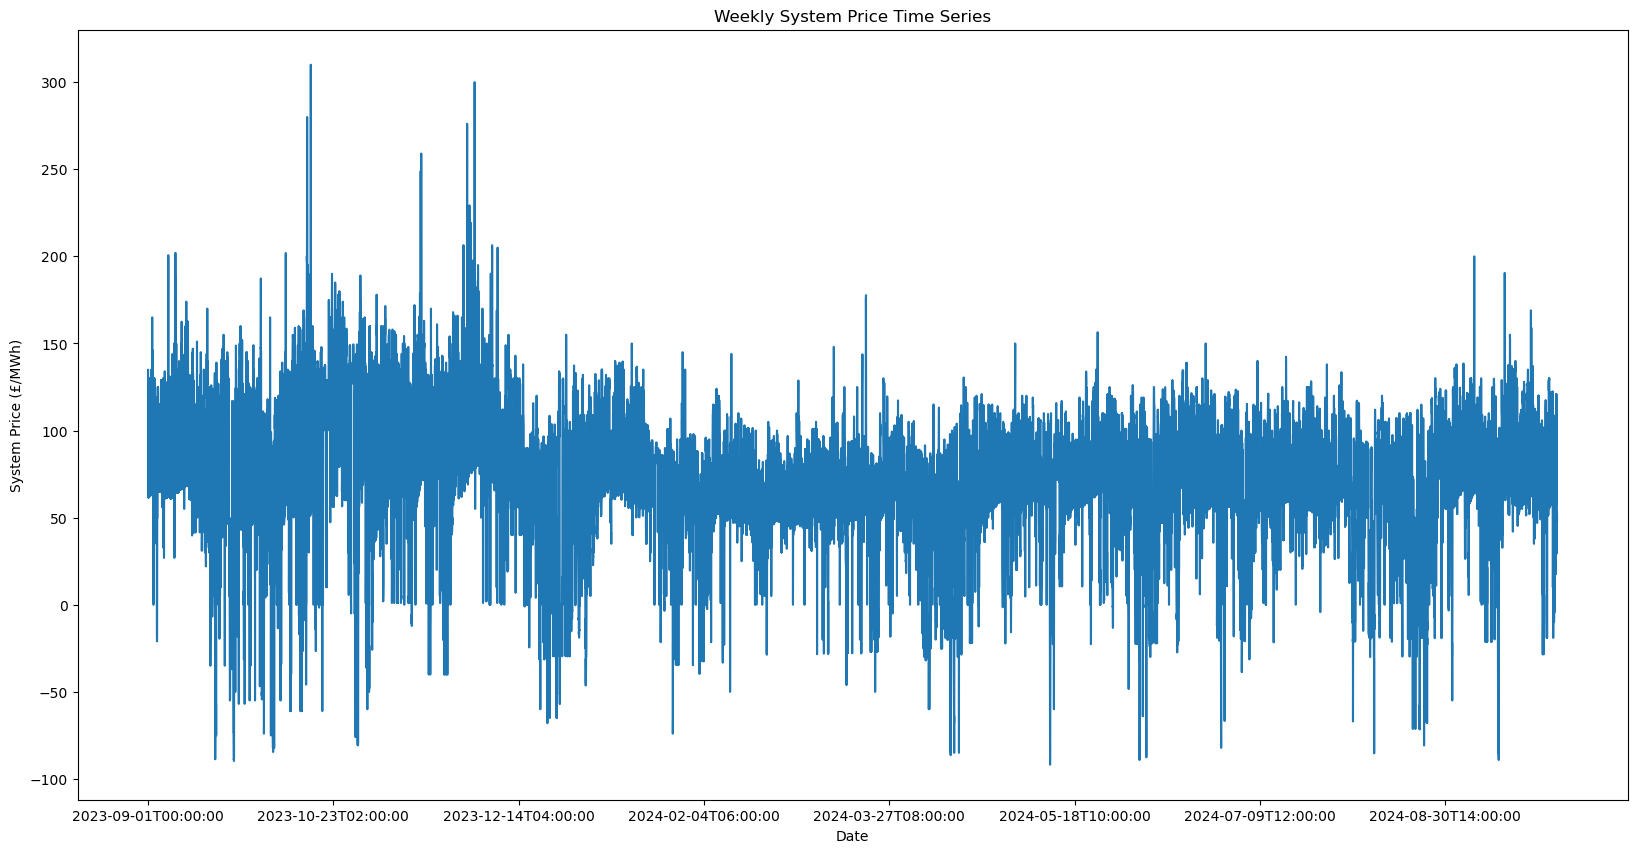

In [ ]:
# Plotting the System Price over a shorter period to check daily patterns
balancing_df_2024['System_Price'][-365*48:].plot(figsize=(20, 10))
plt.title('Weekly System Price Time Series')
plt.xlabel('Date')
plt.ylabel('System Price (£/MWh)')
plt.show()

### ACF and PACF

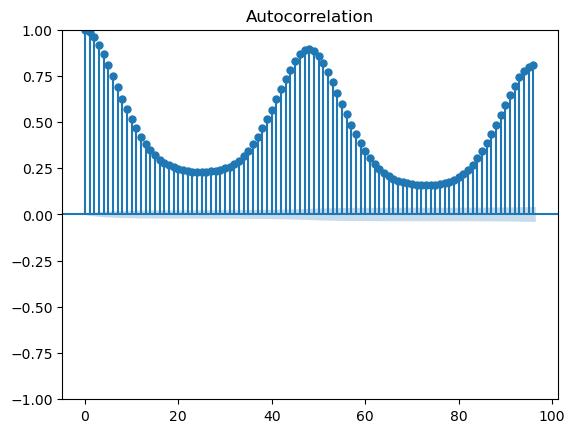

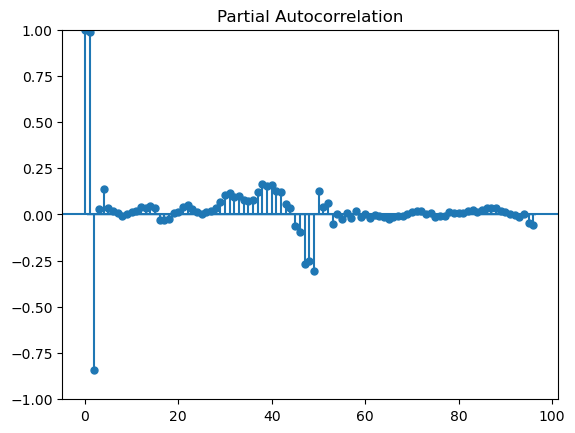

In [ ]:
# Plot ACF
plot_acf(balancing_df['System_Price'].dropna(), lags=96)  # 48 lags cover two days if data is half-hourly
plt.show()

# Plot PACF
plot_pacf(balancing_df['System_Price'].dropna(), lags=96)
plt.show()

### Seasonal Decomposition

# Maybe remove all below (idk if considered EDA)

20:03:47 - cmdstanpy - INFO - Chain [1] start processing
20:04:11 - cmdstanpy - INFO - Chain [1] done processing


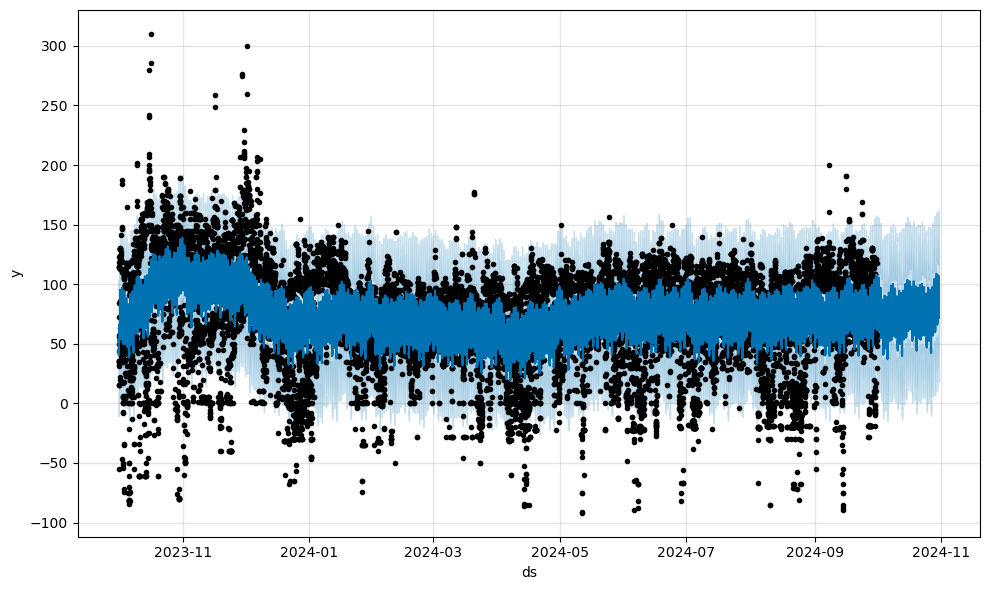

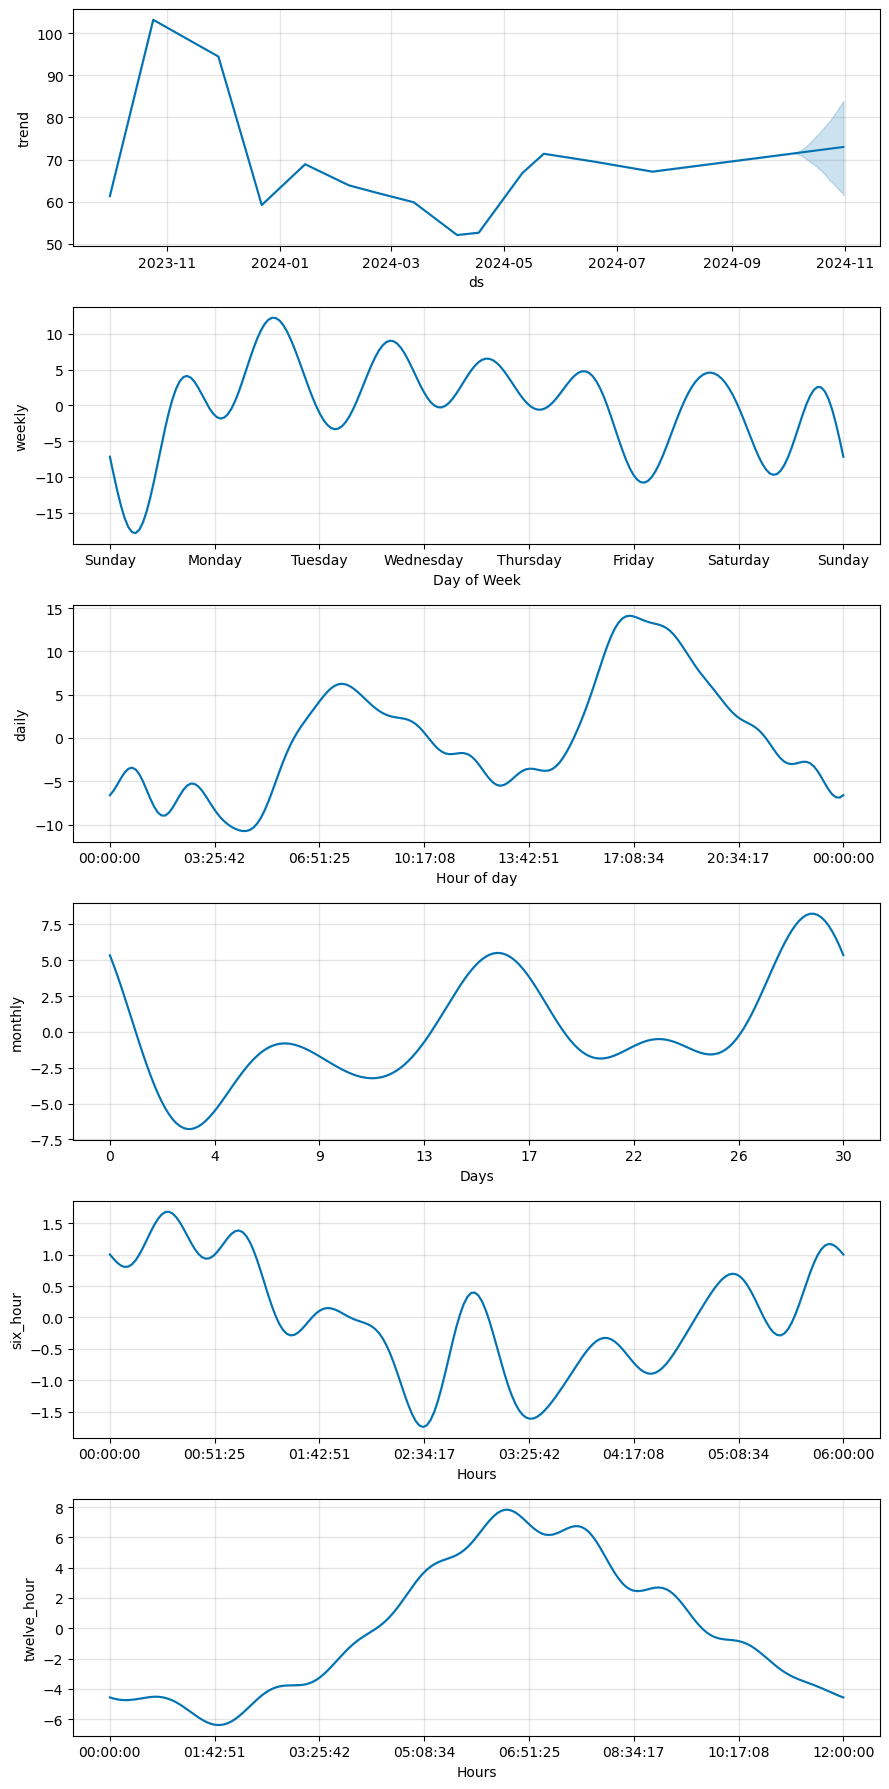

In [ ]:
# Use Prophet to model multiple seasonalities
prophet_balancing_df = balancing_df_2024.reset_index().rename(columns={'GMT Time': 'ds', 'System_Price': 'y'})
model = Prophet()
# Seasonalities are just guesses, we will come back to this later
model.add_seasonality(name='six_hour', period=0.25, fourier_order=10)
model.add_seasonality(name='twelve_hour', period=0.5, fourier_order=10)
model.add_seasonality(name='daily', period=1, fourier_order=15)
model.add_seasonality(name='weekly', period=7, fourier_order=20)
model.add_seasonality(name='monthly', period=30.4375, fourier_order=20)

model.fit(prophet_balancing_df)

# Make future dataframe for predictions, 48 * 30 because we need to predict a month
future = model.make_future_dataframe(periods=48 * 30, freq='30T')
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.show()

# Plot the components
model.plot_components(forecast)
plt.show()

### Fourier Transform for Frequency Analysis
#### Find out which are the important cycles

Frequency: 0.000000 cycles per day, Amplitude: 1233538.41 (DC Component)
Frequency: 0.002732 cycles per day, Amplitude: 105688.40, Period: once every 366.00 days
Frequency: 0.005464 cycles per day, Amplitude: 80342.66, Period: once every 183.00 days
Frequency: 0.008197 cycles per day, Amplitude: 65948.97, Period: once every 122.00 days
Frequency: 0.016393 cycles per day, Amplitude: 60481.43, Period: once every 61.00 days
Frequency: 0.021858 cycles per day, Amplitude: 67139.66, Period: once every 45.75 days
Frequency: 0.024590 cycles per day, Amplitude: 82750.34, Period: once every 40.67 days
Frequency: 0.038251 cycles per day, Amplitude: 51044.91, Period: once every 26.14 days
Frequency: 1.000000 cycles per day, Amplitude: 94105.11, Period: once every 1.00 days
Frequency: 2.000000 cycles per day, Amplitude: 106823.34, Period: once every 0.50 days
Frequency: -2.000000 cycles per day, Amplitude: 106823.34, Period: once every -0.50 days
Frequency: -1.000000 cycles per day, Amplitude: 9410

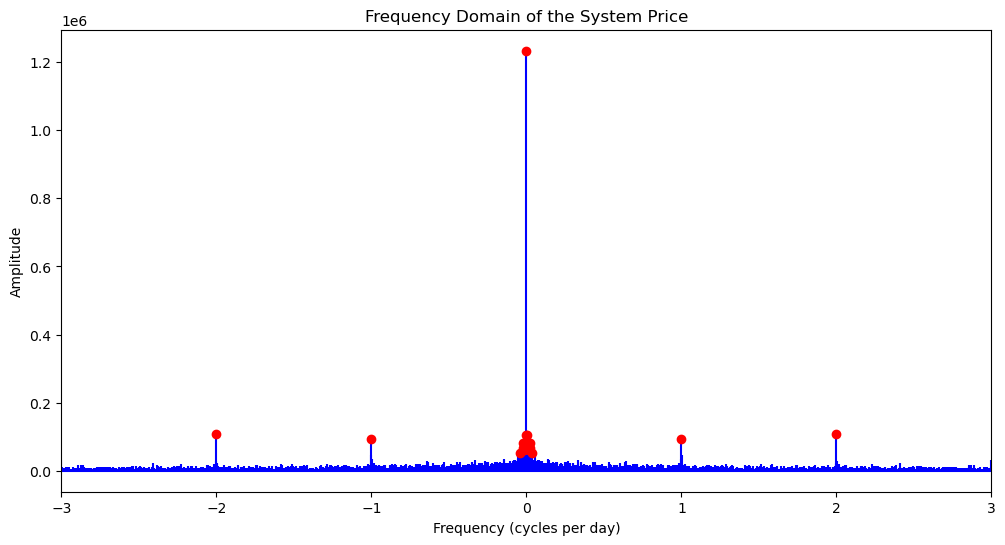

In [ ]:
# Compute fast Fourier transform
price_fft = np.fft.fft(balancing_df_2024['System_Price'].dropna())

# Get frequencies corresponding to FFT coefficients
# d is the interval in terms of days if data is half-hourly, thus frequencies are in cycles per day
freqs = np.fft.fftfreq(len(price_fft), d=1/48)

# Calculate amplitudes
# We need to play with this more I think
amplitudes = np.abs(price_fft)
threshold = 0.04 * np.max(amplitudes)  # Setting a 4% threshold of the maximum amplitude for significance

# Find frequencies with significant amplitudes
significant_freqs = freqs[np.where(amplitudes > threshold)]
significant_amplitudes = amplitudes[np.where(amplitudes > threshold)]

counter = 0
# Print significant frequencies and their amplitudes in a human-readable format
for freq, amp in zip(significant_freqs, significant_amplitudes):
    if freq != 0:
        period_in_days = 1 / freq
        print(f"Frequency: {freq:.6f} cycles per day, Amplitude: {amp:.2f}, Period: once every {period_in_days:.2f} days")
    else:
        print(f"Frequency: {freq:.6f} cycles per day, Amplitude: {amp:.2f} (DC Component)")
    counter += 1
print("There are", counter, "cycles that fit the criteria")

# Plotting the frequency spectrum
plt.figure(figsize=(12, 6))
plt.stem(freqs, amplitudes, 'b', markerfmt=" ", basefmt="-b")
plt.title('Frequency Domain of the System Price')
plt.xlabel('Frequency (cycles per day)')  # Corrected to cycles per day
plt.ylabel('Amplitude')

# Highlight significant frequencies on the plot
for freq, amp in zip(significant_freqs, significant_amplitudes):
    plt.plot(freq, amp, 'ro')  # Mark significant points in red

# Restrict the x-axis to show only -3 to +3
plt.xlim(-3, 3)

plt.show()

### using the fourier transform's result to plug in the seasonalities for the prophet

00:31:15 - cmdstanpy - INFO - Chain [1] start processing
00:31:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ruben\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(


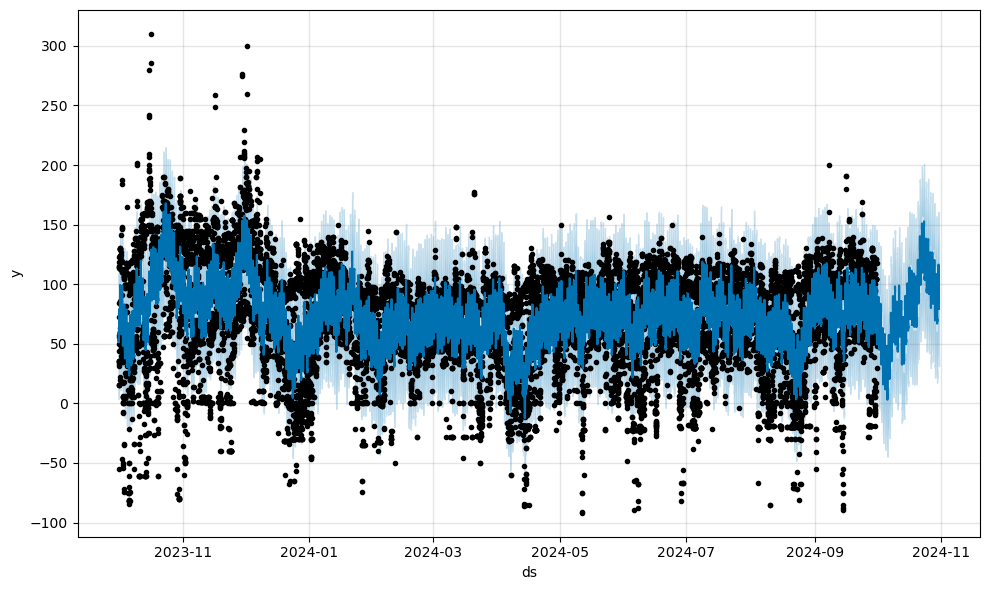

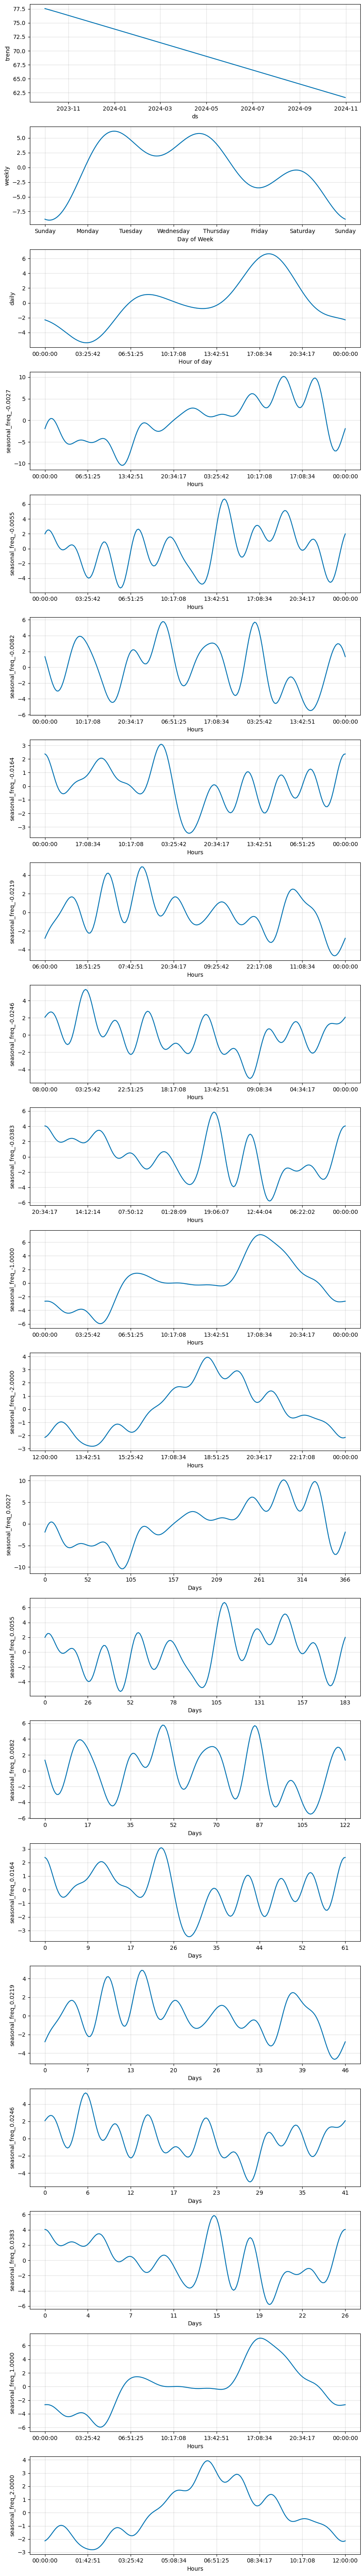

In [ ]:
# Use Prophet to model_F multiple seasonalities
prophet_balancing_df = balancing_df_2024.reset_index().rename(columns={'GMT Time': 'ds', 'System_Price': 'y'})
model_F = Prophet()

# Adding seasonalities based on significant frequencies
for freq, amp in zip(significant_freqs, significant_amplitudes):
    if freq != 0:  # Ignore the DC component
        period_in_days = 1 / freq
        # Add seasonality to Prophet
        seasonality_name = f"seasonal_freq_{freq:.4f}"
        model_F.add_seasonality(name=seasonality_name, period=period_in_days, fourier_order=10)

# Fit the model_F
model_F.fit(prophet_balancing_df)

# Make future dataframe for predictions, 48 * 30 because we need to predict a month
future = model_F.make_future_dataframe(periods=48 * 30, freq='30T')

forecast = model_F.predict(future)

# Plot the forecast
model_F.plot(forecast)
plt.show()

# Plot the components
model_F.plot_components(forecast)
plt.show()

### NIV_Outturn variable analysis

### Visual Inspection

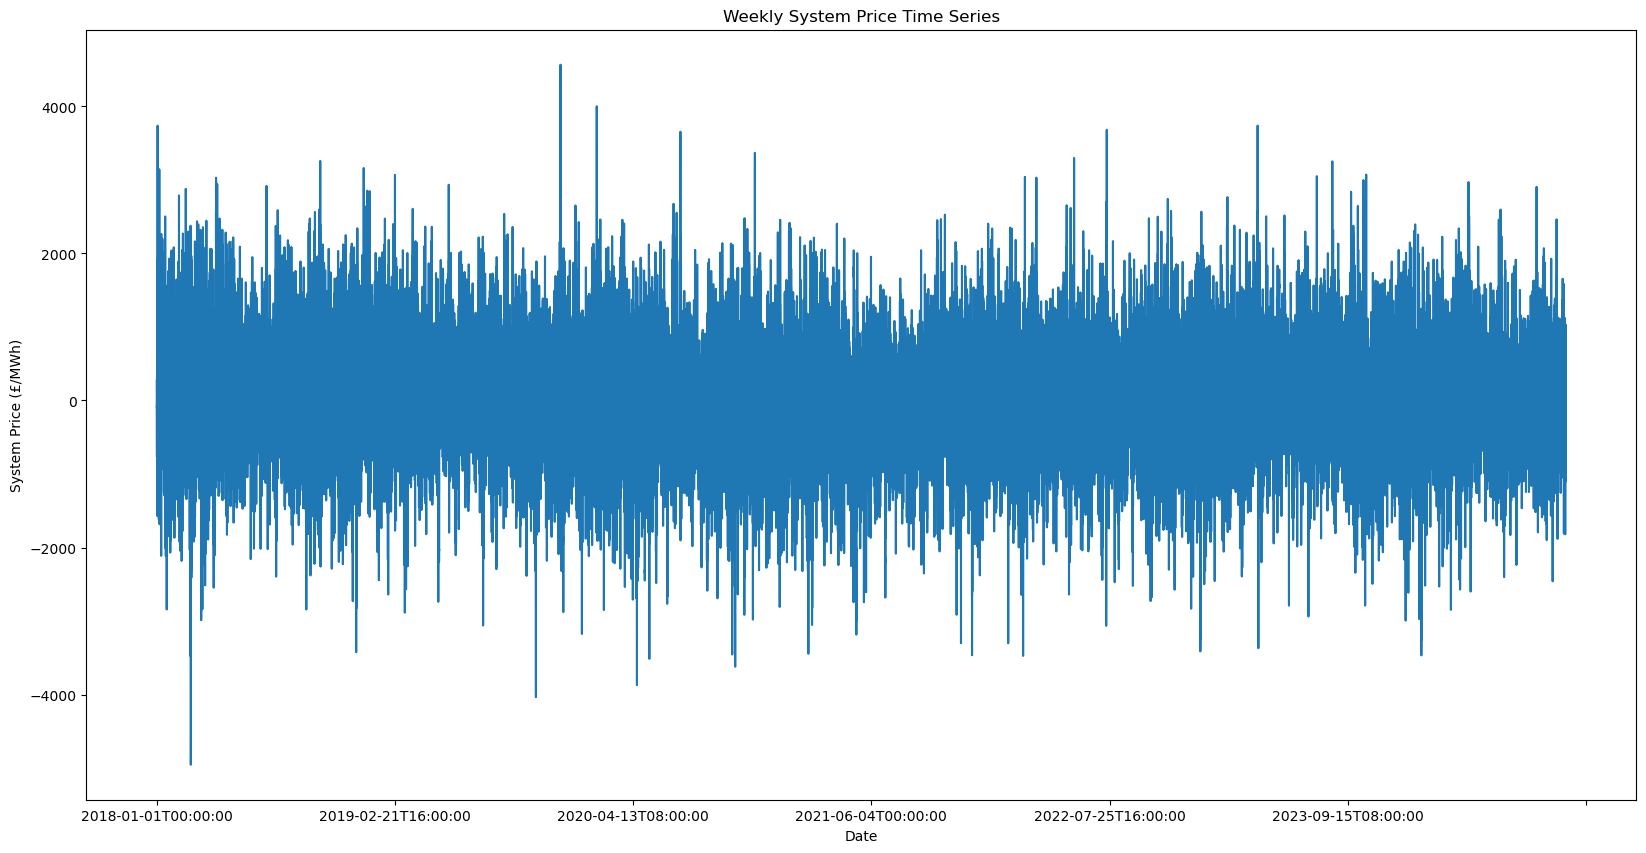

In [ ]:
# Plotting the System Price over total period to check daily patterns
balancing_df['NIV_Outturn'].plot(figsize=(20, 10))
plt.title('Net Imbalance Volume')
plt.xlabel('Date')
plt.ylabel('Net Imbalance Volume (MWh)')
plt.show()

### For the NIV there doesn't seem to be a need to segment, but we'll see

In [ ]:
balancing_df_filtered = balancing_df[(balancing_df.index >= '2018-01-01') & (balancing_df.index < '9999-01-01')]  # we look at everything at first

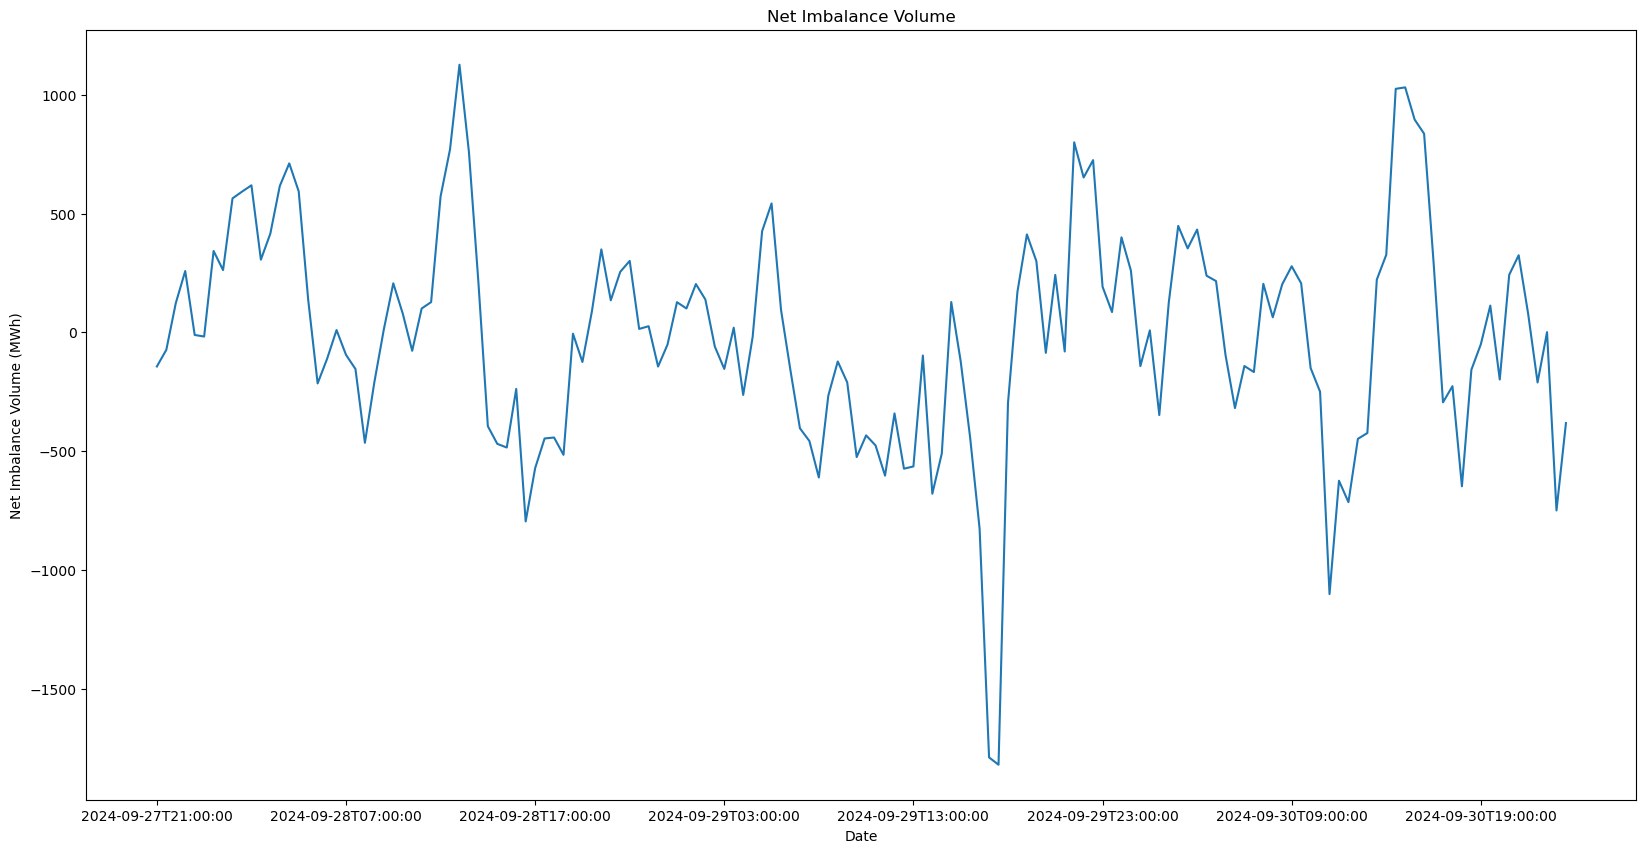

In [ ]:
# Plotting the System Price over a shorter period to check daily patterns
balancing_df_filtered['NIV_Outturn'][-150:].plot(figsize=(20, 10))
plt.title('Net Imbalance Volume')
plt.xlabel('Date')
plt.ylabel('Net Imbalance Volume (MWh)')
plt.show()

### ACF and PACF

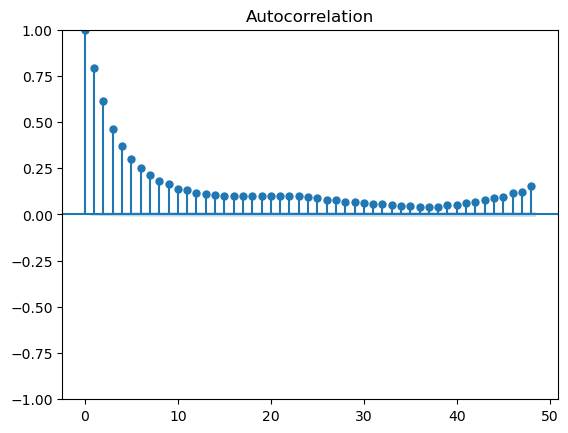

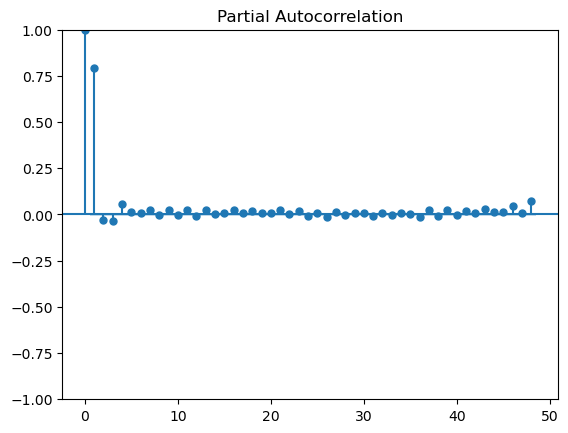

In [ ]:
# Plot ACF
plot_acf(balancing_df_filtered['NIV_Outturn'].dropna(), lags=48)  # 48 lags cover two days if data is half-hourly
plt.show()

# Plot PACF
plot_pacf(balancing_df_filtered['NIV_Outturn'].dropna(), lags=48)
plt.show()

### Seasonal Decomposition

23:07:19 - cmdstanpy - INFO - Chain [1] start processing
23:10:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ruben\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(


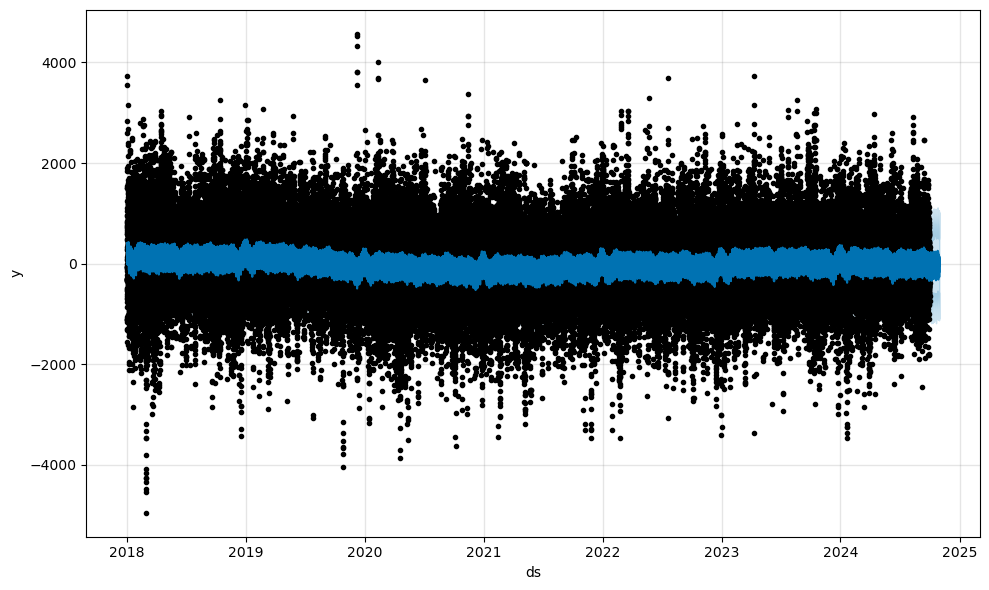

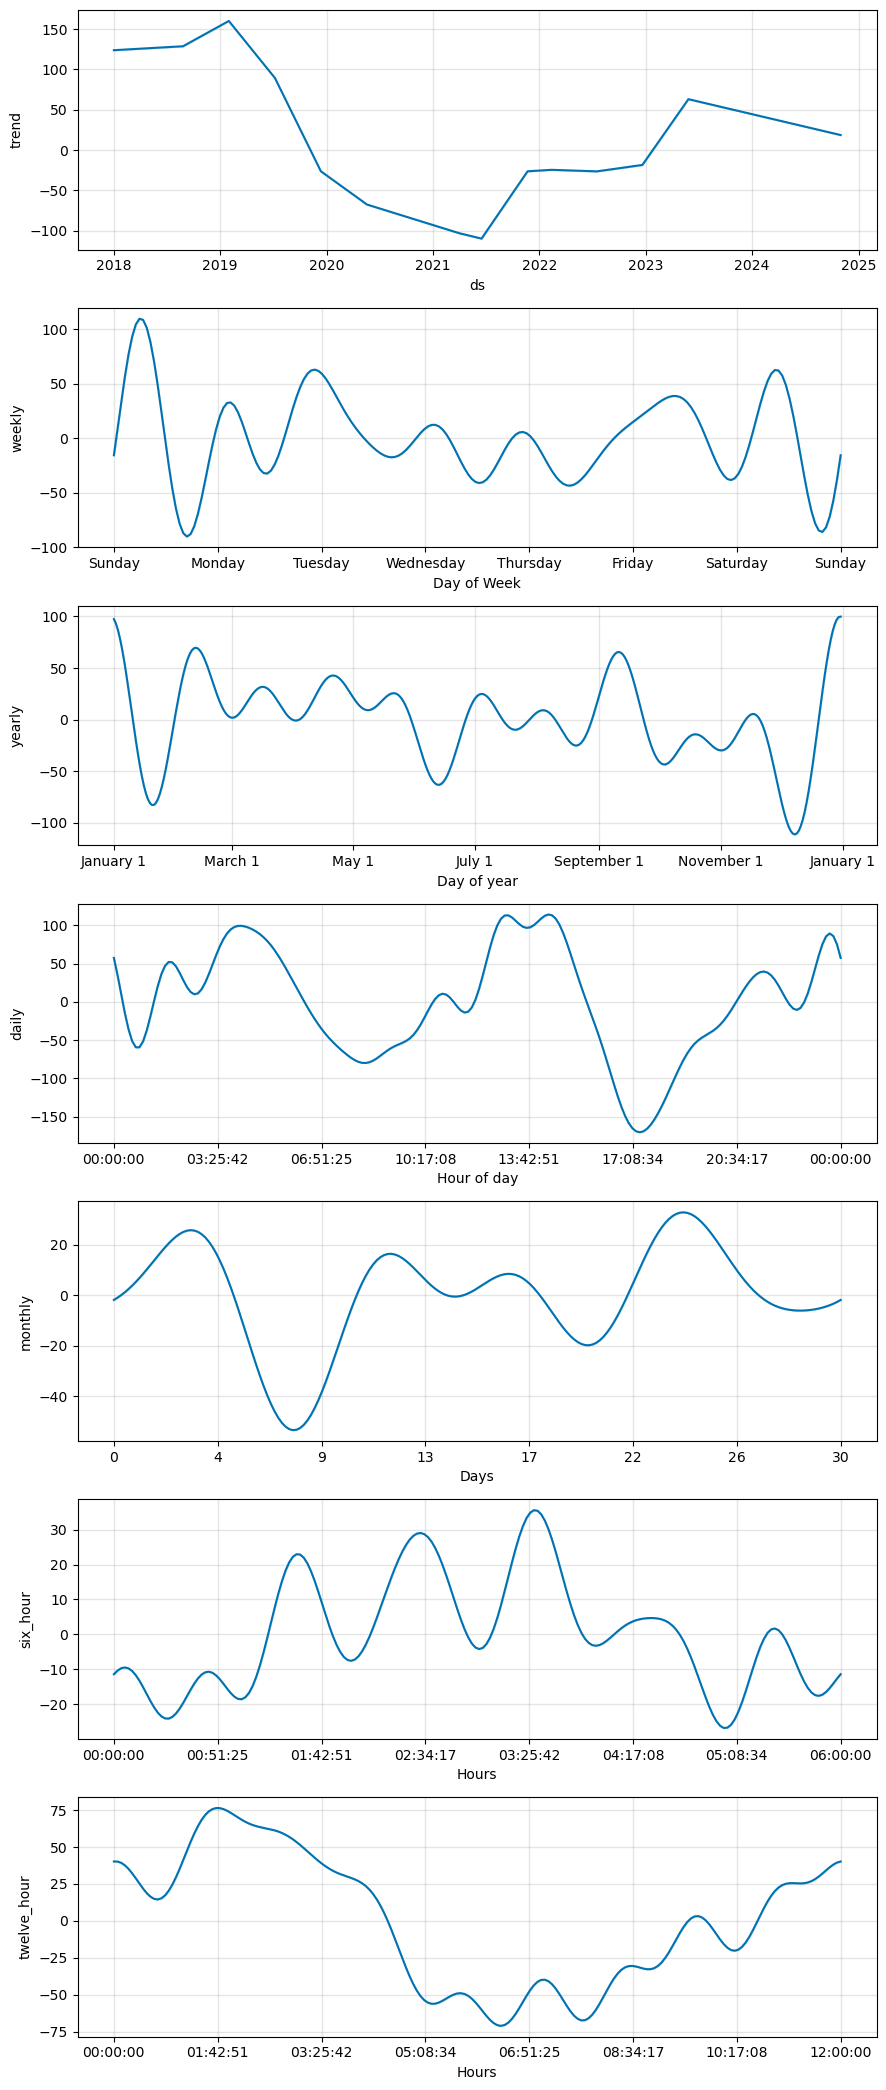

In [ ]:
# Use Prophet to model multiple seasonalities
prophet_balancing_df = balancing_df_filtered.reset_index().rename(columns={'GMT Time': 'ds', 'NIV_Outturn': 'y'})
model = Prophet()
# Seasonalities are just guesses, we will come back to this later
model.add_seasonality(name='six_hour', period=0.25, fourier_order=10)
model.add_seasonality(name='twelve_hour', period=0.5, fourier_order=10)
model.add_seasonality(name='daily', period=1, fourier_order=15)
model.add_seasonality(name='weekly', period=7, fourier_order=10)
model.add_seasonality(name='monthly', period=30.4375, fourier_order=5)

model.fit(prophet_balancing_df)

# Make future dataframe for predictions, 48 * 30 because we need to predict a month
future = model.make_future_dataframe(periods=48 * 30, freq='30T')
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.show()

# Plot the components
model.plot_components(forecast)
plt.show()

### Fourier Transform for Frequency Analysis
#### Find out which are the important cycles

Frequency: 0.000000 cycles per day, Amplitude: 1959657.29 (DC Component)
Frequency: 0.000406 cycles per day, Amplitude: 5815011.58, Period: once every 2464.52 days
Frequency: 0.000812 cycles per day, Amplitude: 2610001.42, Period: once every 1232.26 days
Frequency: 0.007709 cycles per day, Amplitude: 2113971.92, Period: once every 129.71 days
Frequency: 0.008927 cycles per day, Amplitude: 1916285.11, Period: once every 112.02 days
Frequency: 0.010550 cycles per day, Amplitude: 1877851.61, Period: once every 94.79 days
Frequency: 0.016230 cycles per day, Amplitude: 1877266.82, Period: once every 61.61 days
Frequency: 0.035301 cycles per day, Amplitude: 1886512.28, Period: once every 28.33 days
Frequency: 0.044633 cycles per day, Amplitude: 1887660.08, Period: once every 22.40 days
Frequency: 0.047474 cycles per day, Amplitude: 2006782.54, Period: once every 21.06 days
Frequency: 1.000194 cycles per day, Amplitude: 3182502.34, Period: once every 1.00 days
Frequency: 1.001006 cycles per d

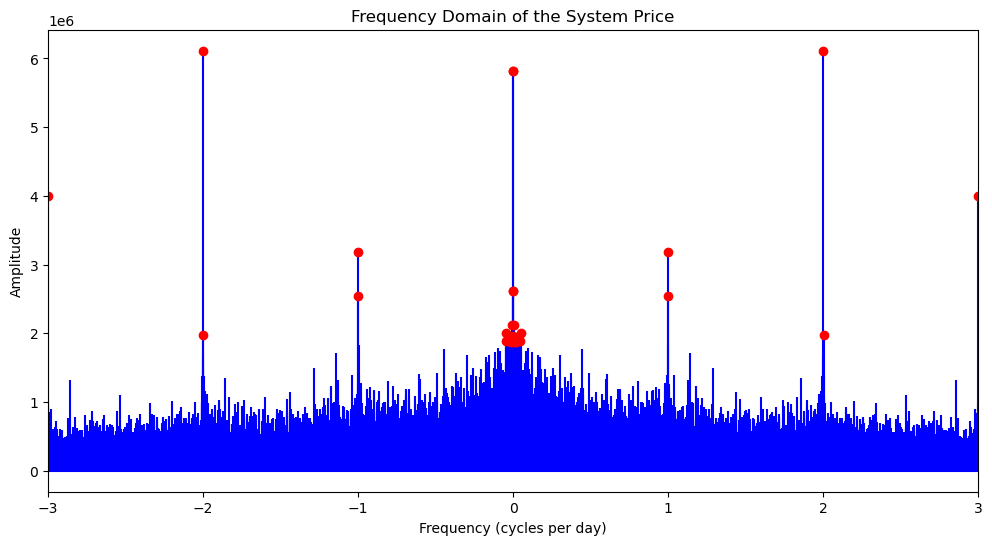

In [ ]:
# Compute fast Fourier transform
price_fft = np.fft.fft(balancing_df_filtered['NIV_Outturn'].dropna())

# Get frequencies corresponding to FFT coefficients
# d is the interval in terms of days if data is half-hourly, thus frequencies are in cycles per day
freqs = np.fft.fftfreq(len(price_fft), d=1/48)

# Calculate amplitudes
# We need to play with this more I think
amplitudes = np.abs(price_fft)
threshold = 0.3 * np.max(amplitudes)  # Setting a 4% threshold of the maximum amplitude for significance

# Find frequencies with significant amplitudes
significant_freqs = freqs[np.where(amplitudes > threshold)]
significant_amplitudes = amplitudes[np.where(amplitudes > threshold)]

counter = 0
# Print significant frequencies and their amplitudes in a human-readable format
for freq, amp in zip(significant_freqs, significant_amplitudes):
    if freq != 0:
        period_in_days = 1 / freq
        print(f"Frequency: {freq:.6f} cycles per day, Amplitude: {amp:.2f}, Period: once every {period_in_days:.2f} days")
    else:
        print(f"Frequency: {freq:.6f} cycles per day, Amplitude: {amp:.2f} (DC Component)")
    counter += 1
print("There are", counter, "cycles that fit the criteria")

# Plotting the frequency spectrum
plt.figure(figsize=(12, 6))
plt.stem(freqs, amplitudes, 'b', markerfmt=" ", basefmt="-b")
plt.title('Frequency Domain of the System Price')
plt.xlabel('Frequency (cycles per day)')  # Corrected to cycles per day
plt.ylabel('Amplitude')

# Highlight significant frequencies on the plot
for freq, amp in zip(significant_freqs, significant_amplitudes):
    plt.plot(freq, amp, 'ro')  # Mark significant points in red

# Restrict the x-axis to show only -3 to +3
plt.xlim(-3, 3)

plt.show()

### using the fourier transform's result to plug in the seasonalities for the prophet

23:11:29 - cmdstanpy - INFO - Chain [1] start processing
23:13:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\ruben\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(


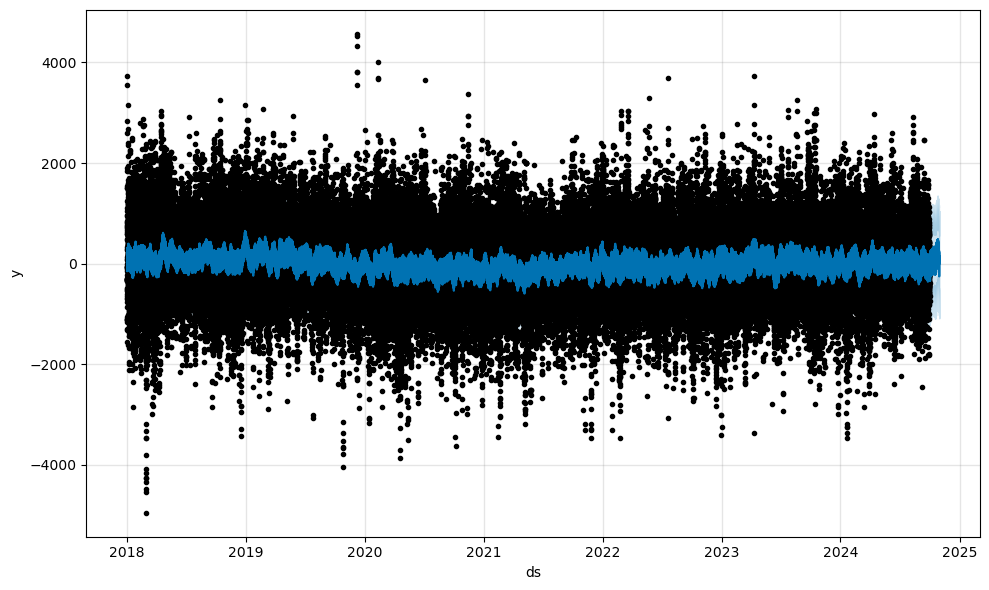

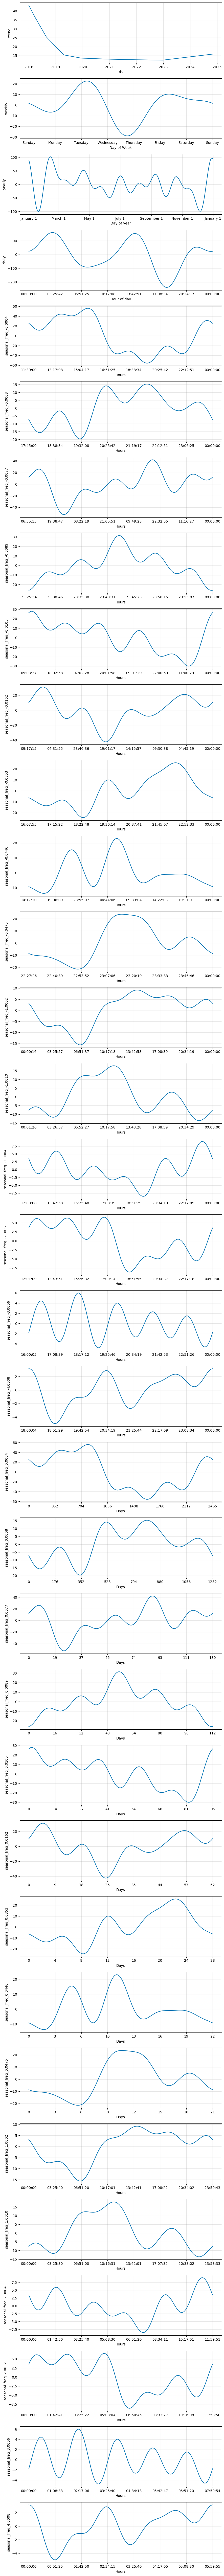

In [ ]:
# Use Prophet to model_F multiple seasonalities
prophet_balancing_df = balancing_df_filtered.reset_index().rename(columns={'GMT Time': 'ds', 'NIV_Outturn': 'y'})
model_F = Prophet()

# Adding seasonalities based on significant frequencies
for freq, amp in zip(significant_freqs, significant_amplitudes):
    if freq != 0:  # Ignore the DC component
        period_in_days = 1 / freq
        # Add seasonality to Prophet
        seasonality_name = f"seasonal_freq_{freq:.4f}"
        model_F.add_seasonality(name=seasonality_name, period=period_in_days, fourier_order=5)

# Fit the model_F
model_F.fit(prophet_balancing_df)

# Make future dataframe for predictions, 48 * 30 because we need to predict a month
future = model_F.make_future_dataframe(periods=48 * 30, freq='30T')
forecast = model_F.predict(future)

# Plot the forecast
model_F.plot(forecast)
plt.show()

# Plot the components
model_F.plot_components(forecast)
plt.show()